In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def bollinger_bands(df, column='Close', window=20, std_dev=2):
    """
    Calculate Bollinger Bands.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data.
    column (str): Column to calculate Bollinger Bands on (default 'Close').
    window (int): Lookback period for SMA (default 20).
    std_dev (int): Standard deviation multiplier (default 2).

    Returns:
    df (pd.DataFrame): DataFrame with 'BB_Middle', 'BB_Upper', and 'BB_Lower' columns.
    """
    df['BB_Middle'] = df[column].rolling(window=window).mean()
    df['BB_Upper'] = df['BB_Middle'] + (df[column].rolling(window=window).std() * std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (df[column].rolling(window=window).std() * std_dev)
    
    return df



def bollinger_band_entry_logic(df):
    """
    Generate entry signals based on Bollinger Bands.
    If no new signal is generated, it carries forward the previous signal.

    Parameters:
    df (pd.DataFrame): DataFrame with Bollinger Bands calculated.

    Returns:
    df (pd.DataFrame): DataFrame with 'Signal' column.
    """
    
    df['Signal'] = 0  # Default to no position

    # Buy Signal (Long Entry) - Price crosses below Lower Band
    df.loc[df['Close'] < df['BB_Lower'], 'Signal'] = 1  

    # Sell Signal (Short Entry) - Price crosses above Upper Band
    df.loc[df['Close'] > df['BB_Upper'], 'Signal'] = -1  

    # **Carry Forward Previous Position**
    df['Signal'] = df['Signal'].replace(0, np.nan).ffill().fillna(0) 

    return df





In [ ]:

def bollinger_bands(df, column='Close', window=20, std_dev=2):
    """
    Calculate Bollinger Bands.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data.
    column (str): Column to calculate Bollinger Bands on (default 'Close').
    window (int): Lookback period for SMA (default 20).
    std_dev (int): Standard deviation multiplier (default 2).

    Returns:
    df (pd.DataFrame): DataFrame with 'BB_Middle', 'BB_Upper', and 'BB_Lower' columns.
    """
    df['BB_Middle'] = df[column].rolling(window=window).mean()
    df['BB_Upper'] = df['BB_Middle'] + (df[column].rolling(window=window).std() * std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (df[column].rolling(window=window).std() * std_dev)
    
    return df



def bollinger_band_entry_logic(df):
    """
    Generate entry signals based on Bollinger Bands.
    If no new signal is generated, it carries forward the previous signal.

    Parameters:
    df (pd.DataFrame): DataFrame with Bollinger Bands calculated.

    Returns:
    df (pd.DataFrame): DataFrame with 'Signal' column.
    """
    
    df['Signal'] = 0  # Default to no position

    # Buy Signal (Long Entry) - Price crosses below Lower Band
    df.loc[df['Close'] < df['BB_Lower'], 'Signal'] = 1  

    # Sell Signal (Short Entry) - Price crosses above Upper Band
    df.loc[df['Close'] > df['BB_Upper'], 'Signal'] = -1  

    # **Carry Forward Previous Position**
    df['Signal'] = df['Signal'].replace(0, np.nan).ffill().fillna(0) 

    return df





In [ ]:
def optimise_param_pf(df:pd.DataFrame, lookback:int,std_dev:float ):
    best_pf = 0
    best_lookback = -1
    r = np.log(df['Close']).diff().shift(-1)
    
    for lookback in range(12,169):
        for std_dev in np.arange(0.5,5,0.5):
            BB = bollinger_bands(df, column= 'Close',window = lookback, std_dev=std_dev)
            signal = bollinger_band_entry_logic(BB)['Signal']
            df['price_chg']= df['Close'].pct_change()
            df['pnl'] = signal.shift(1) * df['price_chg']
            pnl = df['pnl']
            pf = pnl[pnl>0].sum()/pnl[pnl<0].abs().sum()

            if pf > best_pf:
                best_pf = pf
                best_lookback = lookback
                best_std_dev = std_dev

    return best_lookback, best_pf, best_std_dev

In [ ]:
def optimise_param_sr(df:pd.DataFrame, lookback:int,std_dev:float ):
    best_sr = 0
    best_lookback = -1
    r = np.log(df['Close']).diff().shift(-1)
    
    for lookback in range(12,169):
        for std_dev in np.arange(0.5,5,0.5):
            BB = bollinger_bands(df, column= 'Close',window = lookback, std_dev=std_dev)
            signal = bollinger_band_entry_logic(BB)['Signal']
            df['price_chg']= df['Close'].pct_change()
            df['pnl'] = signal.shift(1) * df['price_chg']
            pnl = df['pnl']
            sr = df['pnl'].mean() / df['pnl'].std() * np.sqrt(365)

            if sr > best_sr:
                best_sr = sr
                best_lookback = lookback
                best_std_dev = std_dev

    return best_lookback, best_sr, best_std_dev

/var/folders/rm/g81vx3697gd1lhp947mpdn2w0000gn/T/ipykernel_50147/3818232147.py:13: RuntimeWarning: invalid value encountered in scalar divide
  sr = df['pnl'].mean() / df['pnl'].std() * np.sqrt(365)


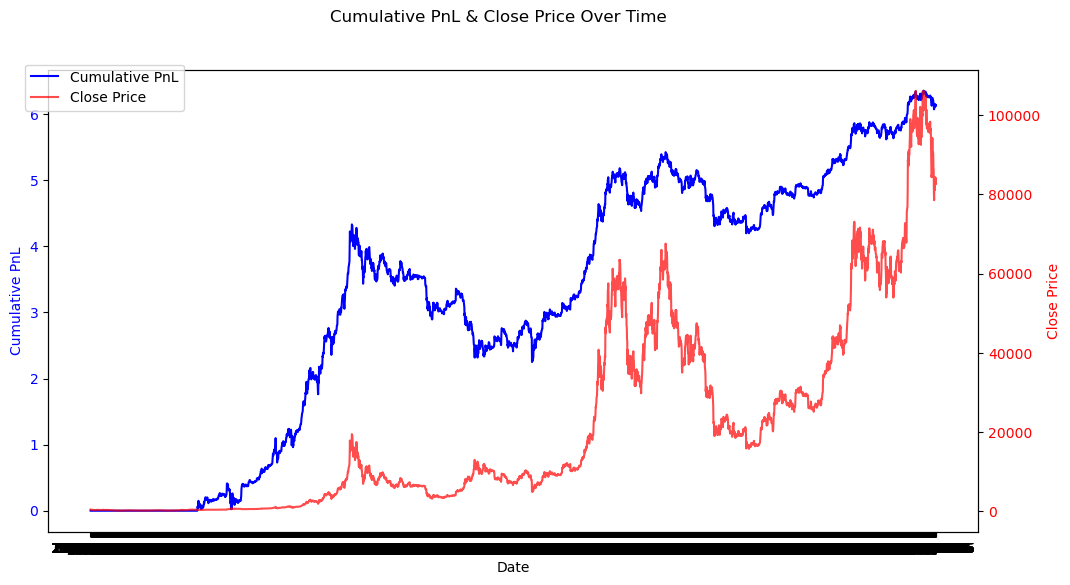

Best Lookback: 21
Best stdev: 3.5
Best Sharpe Ratio: 0.904306429321887
Profit Factor 1.166056619630942
ROI% 6.128758106748866


In [ ]:
#Base on BEST Sharpe Ratio
if __name__ == '__main__':
    # Load Data
    df = pd.read_csv("./btc_price_data_1d.csv")
    df.set_index("time", inplace=True)  # ✅ Corrected indexing

    # Optimize Lookback
    best_lookback, best_sr, best_std_dev = optimise_param_sr(df, lookback=20, std_dev=2.0)  # ✅ Fixed

    df = bollinger_bands(df, column='Close', window=best_lookback, std_dev=best_std_dev)
    # Apply Bollinger Band Entry Logic
    df = bollinger_band_entry_logic(df)  # ✅ No need to assign it

    

    # Calculate Log Returns
    df['price_chg'] = df['Close'].pct_change()

    # Compute P&L using Yesterday's Signal for Today's Price Change
    df['pnl'] = df['Signal'].shift(1) * df['price_chg']  # ✅ Fix applied

    # Calculate and Plot Cumulative P&L
    df['cumu_pnl'] = df['pnl'].cumsum()  # ✅ Store first
   
    sharpe_ratio = df['pnl'].mean() / df['pnl'].std() * np.sqrt(365)

    pnl = df['pnl']
    pf = pnl[pnl>0].sum()/pnl[pnl<0].abs().sum()
    ROI = df['cumu_pnl'].iloc[-1] 

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot cumulative PnL on the primary y-axis (left side)
    ax1.plot(df.index, df['cumu_pnl'], label='Cumulative PnL', color='blue')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative PnL", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for the Close price
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['Close'], label='Close Price', color='red', alpha=0.7)
    ax2.set_ylabel("Close Price", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add title and legend
    fig.suptitle("Cumulative PnL & Close Price Over Time")
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

    plt.show()
    # Print Optimization Results
    print("Best Lookback:", best_lookback)
    print("Best stdev:", best_std_dev)
    print("Best Sharpe Ratio:", best_sr)
    print("Profit Factor",pf)
    print("ROI%", ROI)

/var/folders/rm/g81vx3697gd1lhp947mpdn2w0000gn/T/ipykernel_41241/3840525453.py:13: RuntimeWarning: invalid value encountered in scalar divide
  pf = pnl[pnl>0].sum()/pnl[pnl<0].abs().sum()


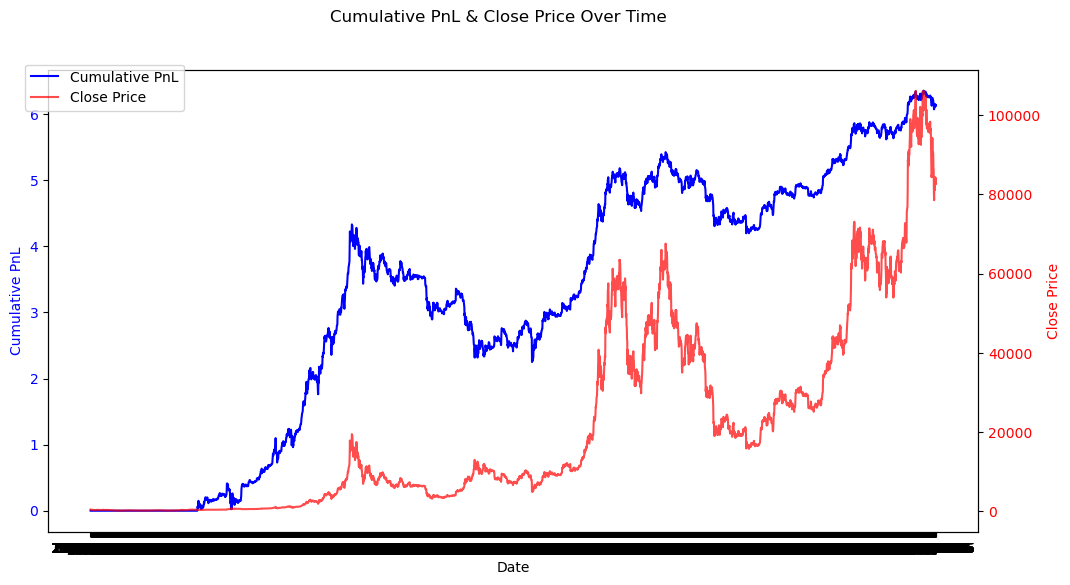

Best Lookback: 21
Best stdev: 3.5
Best Profit Factor: 1.166056619630942
Sharpe Ratio 0.904306429321887
ROI% 6.128758106748866


In [ ]:
#Base on BEST profit factor
if __name__ == '__main__':
    # Load Data
    df = pd.read_csv("/Users/anson/Documents/Python_Code/Cybotrade_Projects/ssh-keys/cybotrade/YouTube_Shooting/Data/BTC/btc_price_data_1d.csv")
    df.set_index("time", inplace=True)  # ✅ Corrected indexing

    # Optimize Lookback
    best_lookback, best_pf, best_std_dev = optimise_param_pf(df, lookback=20, std_dev=2.0)  # ✅ Fixed

    df = bollinger_bands(df, column='Close', window=best_lookback, std_dev=best_std_dev)
    # Apply Bollinger Band Entry Logic
    df = bollinger_band_entry_logic(df)  # ✅ No need to assign it

    

    # Calculate Log Returns
    df['price_chg'] = df['Close'].pct_change()

    # Compute P&L using Yesterday's Signal for Today's Price Change
    df['pnl'] = df['Signal'].shift(1) * df['price_chg']  # ✅ Fix applied

    # Calculate and Plot Cumulative P&L
    df['cumu_pnl'] = df['pnl'].cumsum()  # ✅ Store first
   
    sharpe_ratio = df['pnl'].mean() / df['pnl'].std() * np.sqrt(365)
    ROI = df['cumu_pnl'].iloc[-1] 


    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot cumulative PnL on the primary y-axis (left side)
    ax1.plot(df.index, df['cumu_pnl'], label='Cumulative PnL', color='blue')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative PnL", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis for the Close price
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['Close'], label='Close Price', color='red', alpha=0.7)
    ax2.set_ylabel("Close Price", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add title and legend
    fig.suptitle("Cumulative PnL & Close Price Over Time")
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

    plt.show()
    # Print Optimization Results
    print("Best Lookback:", best_lookback)
    print("Best stdev:", best_std_dev)
    print("Best Profit Factor:", best_pf)
    print("Sharpe Ratio",sharpe_ratio)
    print("ROI%", ROI)

In [ ]:
df.to_csv("./BB_breakout_backtest.csv")